In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sql_functions as sf
import capstone_functions as cf
import itertools

# this so called "line magic" command, amongst other things, stores the plots in the notebook document.
%matplotlib inline

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

### Variables

In [297]:
schema = "bgg_data"
ks_table = "clean_ks_with_bgg_id"
main_stats_table = "unfiltered_main_stats_cleaned"
engine = sf.get_engine()

### Fetch the data from DB and merge into one Dataframe

In [298]:
ks_query = f"SELECT * from {schema}.{ks_table};"
main_query = f"SELECT * FROM {schema}.{main_stats_table};"

In [299]:
df_ks = sf.get_dataframe(ks_query)
df_main = sf.get_dataframe(main_query)
df_ks.rename({'bgg_id':'id'},axis=1,inplace=True)

In [300]:
df = pd.merge(df_ks,df_main,how='inner',on='id')

- Drop all non-numerical values (including Timestamps)  
- Afterwards use the z-score to truncate all the outliers of specific columns (min_playtime)

In [301]:
df.drop(['yearpublished','deadline', 'created_at','playtime', 'launched_at','state_changed_at','successful','country','currency','averageweight'],axis=1,inplace=True)

In [302]:
df.dropna(axis=0,inplace=True)

#### Choose the independent variable (Predictor)

In [303]:

df = df[(np.abs(stats.zscore(df['min_playtime'])) < 2)]
df = df[(np.abs(stats.zscore(df['max_playtime'])) < 2)]
df = df[(np.abs(stats.zscore(df['max_players'])) < 2)]
df = df[(np.abs(stats.zscore(df['min_players'])) < 3)]
df = df[df["min_age"] < 19]

In [311]:
columns_list = df.columns.to_list()

In [316]:
columns_list.pop(4)

'usd_pledged'

In [317]:
columns_list

['id',
 'goal',
 'pledged',
 'backers_count',
 'min_players',
 'max_players',
 'min_playtime',
 'max_playtime',
 'min_age',
 'average',
 'user_rated',
 'num_owned',
 'trading',
 'wanting',
 'wishing',
 'numcomments',
 'numweights']

In [305]:
X = df[['average','min_players','max_players','min_playtime','max_playtime','min_age','wanting','trading']]

In [354]:
columns_list = df.columns.to_list()
columns_list.pop(4);
columns_combinations = []
temp_list = []
temp_list.append(columns_list[0])
for i in range(1,len(columns_list)):
    temp_list.append(columns_list[i])
    print(temp_list)
    columns_combinations.append(temp_list.copy())
    print(columns_combinations)
    if i == 2:
        break

['id', 'goal']
[['id', 'goal']]
['id', 'goal', 'pledged']
[['id', 'goal'], ['id', 'goal', 'pledged']]


In [336]:
columns_combinations

[['id', 'goal', 'pledged'], ['id', 'goal', 'pledged']]

In [318]:
for col in columns_list:
    formula = f"usd_pledged ~ {col}"
    rs = smf.ols(formula=formula, data=df).fit().rsquared
    print(f'{formula}:   {rs:.3}')


usd_pledged ~ id:   0.00312
usd_pledged ~ goal:   0.0937
usd_pledged ~ pledged:   0.698
usd_pledged ~ backers_count:   0.672
usd_pledged ~ usd_pledged:   1.0
usd_pledged ~ min_players:   0.0189
usd_pledged ~ max_players:   0.000565
usd_pledged ~ min_playtime:   0.0205
usd_pledged ~ max_playtime:   0.0219
usd_pledged ~ min_age:   0.016
usd_pledged ~ average:   0.0107
usd_pledged ~ user_rated:   0.0509
usd_pledged ~ num_owned:   0.0906
usd_pledged ~ trading:   0.0585
usd_pledged ~ wanting:   0.0511
usd_pledged ~ wishing:   0.0642
usd_pledged ~ numcomments:   0.0732
usd_pledged ~ numweights:   0.0335


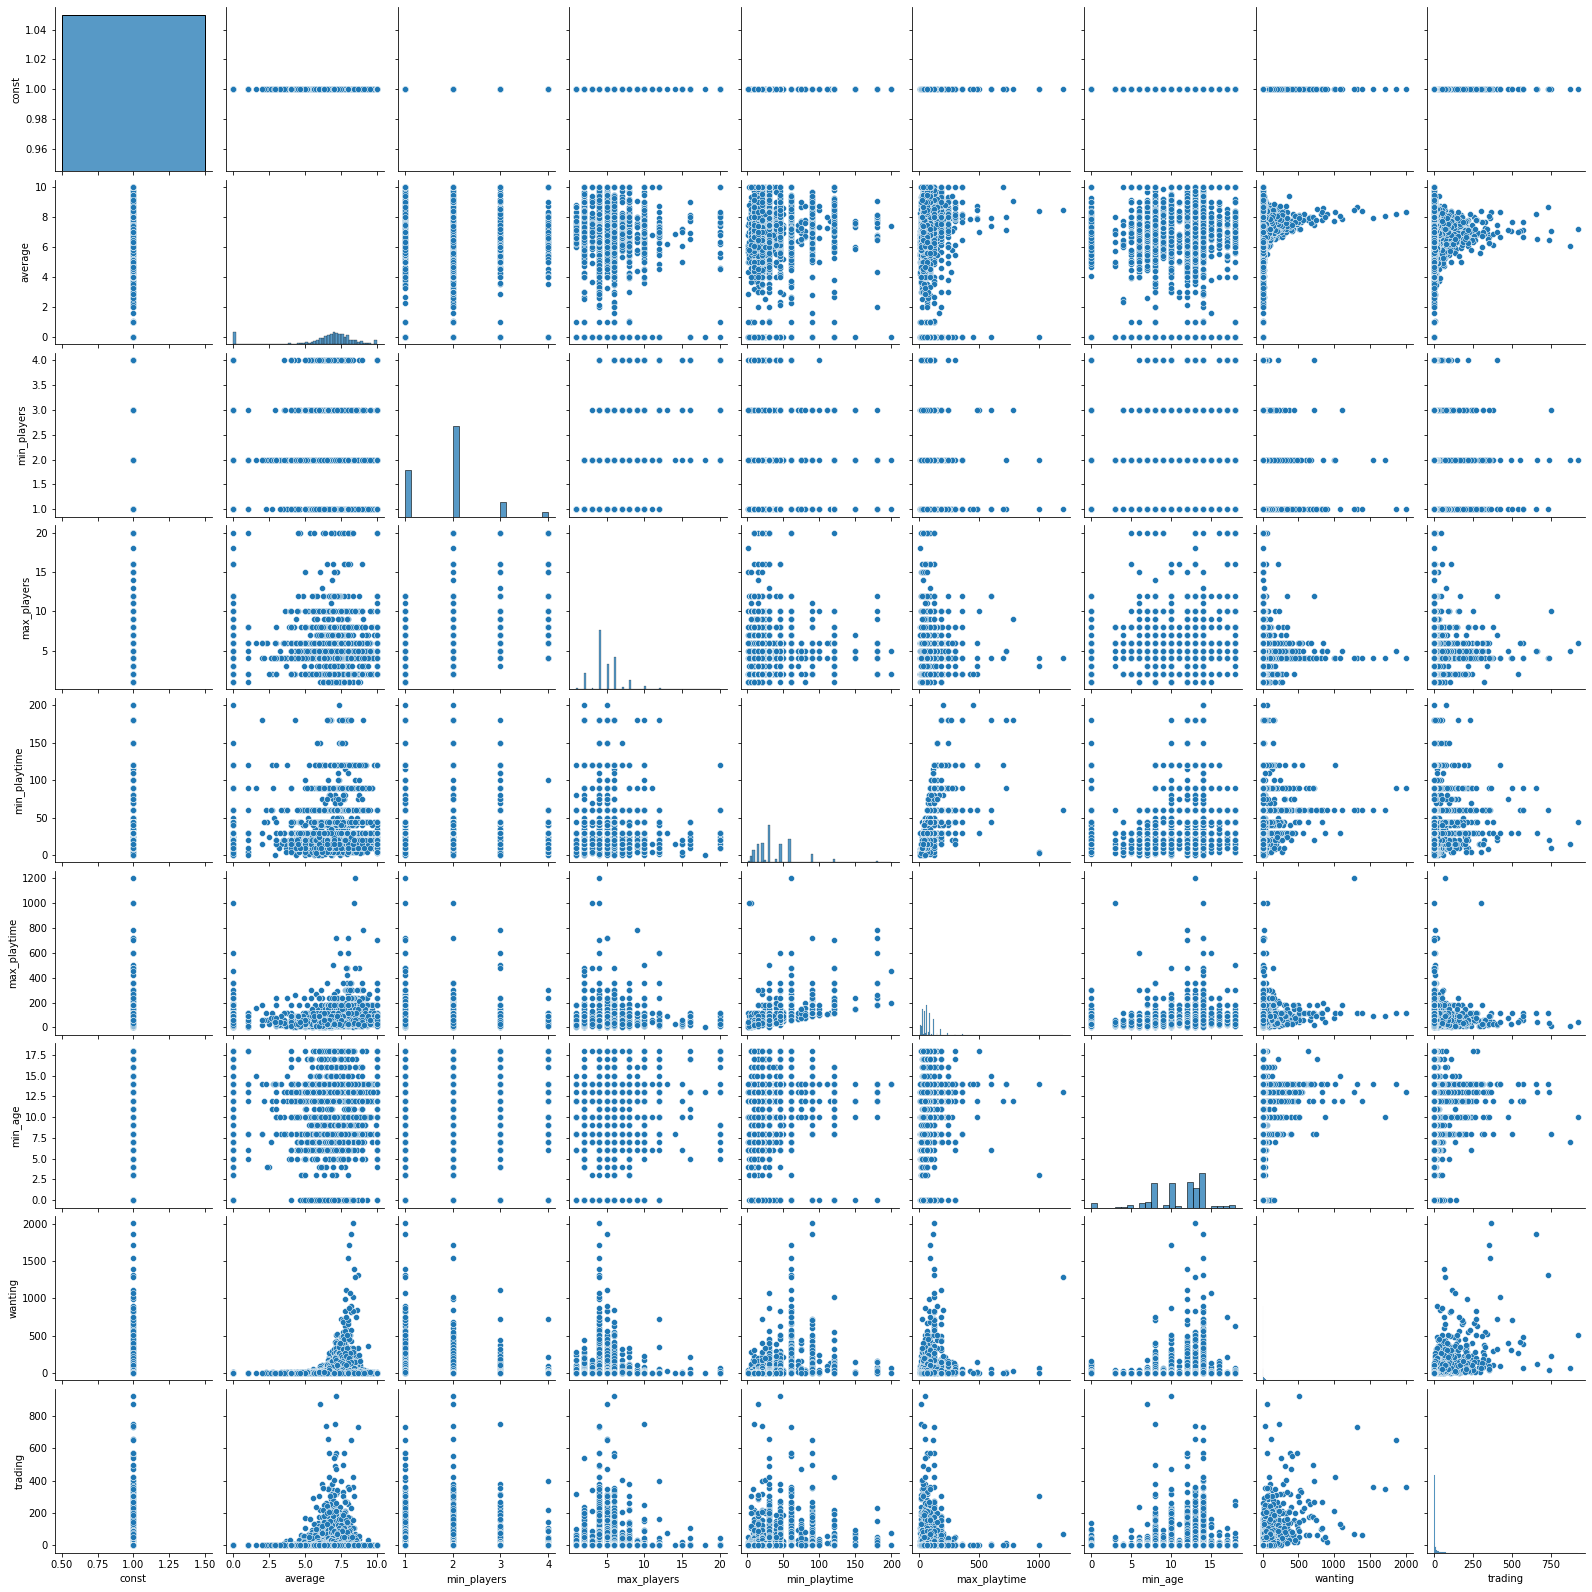

In [355]:
sns.pairplot(X);

- Define dependent variable (since it's always a single variable, we can use dot notation here)
- Since our statsmodel OLS model needs an adjustable intercept, we add a column of 1s to:

In [307]:
y = df.usd_pledged
X = sm.add_constant(X)

display(X.head())

,const,average,min_players,max_players,min_playtime,max_playtime,min_age,wanting,trading
0,1.0,5.80000,2.0,4.0,120.0,120.0,12,21,20
1,1.0,7.16305,2.0,6.0,60.0,60.0,10,395,240
2,1.0,6.96499,3.0,6.0,75.0,75.0,12,157,154
3,1.0,6.15566,3.0,8.0,45.0,45.0,12,99,376
5,1.0,6.06458,2.0,4.0,60.0,60.0,12,16,26


Now, our data is prepared for modelling!  

The following steps are:
- creating a model based on the modules notation,
- fitting the model to our data (this is the part where the sum of squared residuals is reduced to min - and passing the model results in a result variable)
- print a summary with the models statistics

In [308]:
# Prepare data for modeling
# X3 is already defined, we still need to add the constand though:
X = sm.add_constant(X)

#fit model and get model summery in one step
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usd_pledged   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     58.59
Date:                Mon, 11 Jul 2022   Prob (F-statistic):           6.92e-91
Time:                        15:52:26   Log-Likelihood:                -59353.
No. Observations:                4094   AIC:                         1.187e+05
Df Residuals:                    4085   BIC:                         1.188e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.222e+04   4.11e+04     -1.272      0.203   -1.33e+05    2.83e+04
average       1.099e+04   3376.122      3.255      0.001    4370.604    1.76e+04
min_players  -6.894e+04   1.21e+04     -5.707      0.000   -9.26e+04   -4.53e+04
max_players   4760.6123   3628.343      1.312      0.190   -2352.916    1.19e+04
min_playtime   243.3896    349.056      0.697      0.486    -440.951     927.730
max_playtime   701.6646    146.747      4.781      0.000     413.960     989.369
min_age       9445.5875   2310.163      4.089      0.000    4916.409     1.4e+04
wanting        397.9120     85.540      4.652      0.000     230.206     565.618
trading       1474.4002    148.564      9.924      0.000    1183.134    1765.666
==============================================================================
Omnibus:                     6872.713   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6580318.470
Skew:                          11.252   Prob(JB):                         0.00
Kurtosis:                     198.113   Cond. No.                         733.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# print out the intercept and slope of your model by adressing the parameters via ".params"
# (you can also find it in the table above by looking at const coef and weight coef)
intercept, slope = model_results.params

print(f'intercept: {intercept}, slope: {slope}')

ValueError: too many values to unpack (expected 2)